In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
Train_data = pd.read_csv('E:/OpenData/CarPrice/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('E:/OpenData/CarPrice/used_car_testA_20200313.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [3]:
## 通过.head() 简要浏览读取数据的形式
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
## 通过 .columns 查看列名
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [5]:
TestA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

In [7]:
feature_cols = ['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14']

In [8]:
## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 30)
X test shape: (50000, 30)


In [33]:
X_data['notRepairedDamage'].replace('-',-1,inplace=True)
X_data['notRepairedDamage'] = X_data['notRepairedDamage'].astype('float')
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [34]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [35]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105000 entries, 33365 to 71516
Data columns (total 30 columns):
SaleID               105000 non-null int64
name                 105000 non-null int64
regDate              105000 non-null int64
model                105000 non-null float64
brand                105000 non-null int64
bodyType             105000 non-null float64
fuelType             105000 non-null float64
gearbox              105000 non-null float64
power                105000 non-null int64
kilometer            105000 non-null float64
notRepairedDamage    105000 non-null float64
regionCode           105000 non-null int64
seller               105000 non-null int64
offerType            105000 non-null int64
creatDate            105000 non-null int64
v_0                  105000 non-null float64
v_1                  105000 non-null float64
v_2                  105000 non-null float64
v_3                  105000 non-null float64
v_4                  105000 non-null float64
v_5 

In [36]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [37]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [39]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)



Train lgb...
MAE of val with lgb: 587.7933002196957


In [40]:
X_test['notRepairedDamage'].replace('-',-1,inplace=True)
X_test['notRepairedDamage'] = X_test['notRepairedDamage'].astype('float')
print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Predict lgb...
Sta of Predict lgb:
_min -669.825427683281
_max: 93521.07596338016
_mean 5945.872495388761
_ptp 94190.90139106344
_std 7447.0617640174305
_var 55458728.9170904


In [41]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

Train xgb...
MAE of val with xgb: 615.1759528512848


In [42]:
print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Predict xgb...
Sta of Predict xgb:
_min -627.95197
_max: 94084.55
_mean 5930.9683
_ptp 94712.5
_std 7382.8
_var 54505736.0


In [43]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 581.7647330677318


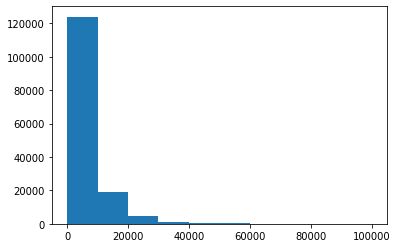

In [47]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

In [48]:
sub_Weighted[sub_Weighted<0]=10
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted_0322.csv',index=False)

In [49]:
sub.head()

,SaleID,price
0,150000,40476.357441
1,150001,274.990557
2,150002,6054.057321
3,150003,11898.541130
4,150004,578.148066


In [53]:
print(pd.DataFrame({
        'column': feature_cols,
        'importance': model_lgb_pre.best_estimator_.feature_importances_,
    }).sort_values(by='importance'))

               column  importance
12             seller           0
13          offerType           0
7             gearbox          85
6            fuelType         135
10  notRepairedDamage         184
5            bodyType         186
4               brand         435
14          creatDate         442
19                v_4         444
1                name         505
20                v_5         510
3               model         531
24                v_9         552
26               v_11         579
28               v_13         618
17                v_2         623
0              SaleID         639
22                v_7         646
23                v_8         646
9           kilometer         650
11         regionCode         698
27               v_12         714
15                v_0         845
16                v_1         901
18                v_3         926
25               v_10         965
21                v_6        1061
29               v_14        1081
8             

In [51]:
print(model_lgb_pre.best_params_)

{'learning_rate': 0.1}


In [52]:
print(model_lgb_pre.best_estimator_.feature_importances_)

[ 639  505 1982  531  435  186  135   85 1317  650  184  698    0    0
  442  845  901  623  926  444  510 1061  646  646  552  965  579  714
  618 1081]
